In [11]:
# Imports and path setup
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# ensure project root is importable so `lib` package resolves
ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# Notebook display options
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

In [12]:
# Load minimal project utilities
from lib.layers import Dense
from lib.activations import ReLU, Sigmoid
from lib.network import Model
from lib.losses import MSELoss
from lib.optimizer import SGD
from lib.utils import to_batches

print('lib package imported successfully')

lib package imported successfully


## Data: load MNIST (local `mnist.npz` or download)
The notebook will look for `mnist.npz` in the project root and download it if missing.

In [13]:
mnist_path = os.path.join(ROOT, 'mnist.npz')
if os.path.exists(mnist_path):
    print('Found local mnist.npz')
    with np.load(mnist_path, allow_pickle=True) as data:
        x_train, y_train = data['x_train'], data['y_train']
        x_test, y_test = data['x_test'], data['y_test']
else:
    print('Downloading mnist.npz...')
    url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
    import urllib.request
    urllib.request.urlretrieve(url, mnist_path)
    with np.load(mnist_path, allow_pickle=True) as data:
        x_train, y_train = data['x_train'], data['y_train']
        x_test, y_test = data['x_test'], data['y_test']

# normalize and flatten
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_flat = x_train.reshape((-1, 28*28))
x_test_flat = x_test.reshape((-1, 28*28))

print('Train shape:', x_train_flat.shape, 'Test shape:', x_test_flat.shape)

Found local mnist.npz
Train shape: (60000, 784) Test shape: (10000, 784)
Train shape: (60000, 784) Test shape: (10000, 784)


## Define autoencoder using `lib` layers
We create layer objects and build two `Model` instances: the full autoencoder and the encoder (prefix).

In [14]:
def build_autoencoder_layers(input_dim=784, latent_dim=32):
    enc_fc1 = Dense(512, init='xavier')
    enc_act1 = ReLU()
    enc_fc2 = Dense(256, init='xavier')
    enc_act2 = ReLU()
    enc_fc3 = Dense(128, init='xavier')
    enc_act3 = ReLU()
    enc_fc4 = Dense(64, init='xavier')
    enc_act4 = ReLU()
    enc_latent = Dense(latent_dim, init='xavier')
    enc_latent_act = ReLU()
    dec_fc1 = Dense(64, init='xavier')
    dec_act1 = ReLU()
    dec_fc2 = Dense(128, init='xavier')
    dec_act2 = ReLU()
    dec_fc3 = Dense(256, init='xavier')
    dec_act3 = ReLU()
    dec_fc4 = Dense(512, init='xavier')
    dec_act4 = ReLU()
    dec_out = Dense(input_dim, init='xavier')
    dec_out_act = Sigmoid()

    encoder_layers = [enc_fc1, enc_act1, enc_fc2, enc_act2, enc_fc3, enc_act3, enc_fc4, enc_act4, enc_latent, enc_latent_act]
    decoder_layers = [dec_fc1, dec_act1, dec_fc2, dec_act2, dec_fc3, dec_act3, dec_fc4, dec_act4, dec_out, dec_out_act]
    return encoder_layers, decoder_layers

def build_autoencoder_model(encoder_layers, decoder_layers):
    model = Model()
    for layer in encoder_layers + decoder_layers:
        model.add(layer)
    return model

def build_encoder_model(encoder_layers):
    enc_model = Model()
    for layer in encoder_layers:
        enc_model.add(layer)
    return enc_model

## Train autoencoder (quick smoke test options)
We'll run a short training pass here; increase `epochs` for full training.

In [15]:
# Config (adjust as needed)
latent_dim = 32
batch_size = 32
epochs = 40  # increase to 30 or more for full training
auto_lr = 0.05
np.random.seed(42)

encoder_layers, decoder_layers = build_autoencoder_layers(input_dim=28*28, latent_dim=latent_dim)
auto = build_autoencoder_model(encoder_layers, decoder_layers)
encoder = build_encoder_model(encoder_layers)

# initialize parameters by a dummy forward (Dense.build is lazy)
dummy = np.zeros((1, 28*28), dtype=np.float32)
_ = auto.predict(dummy)

auto.compile(optimizer=lambda params: SGD(params, lr=auto_lr), loss=MSELoss())
history = auto.fit(x_train_flat, x_train_flat, epochs=epochs, batch_size=batch_size, verbose=1)

# quick evaluation
x_test_recon = auto.predict(x_test_flat)
test_mse = np.mean((x_test_flat - x_test_recon) ** 2)
print('Test reconstruction MSE:', test_mse)

Epoch 1/40 - loss: 0.088224
Epoch 4/40 - loss: 0.060163
Epoch 4/40 - loss: 0.060163
Epoch 8/40 - loss: 0.051545
Epoch 8/40 - loss: 0.051545
Epoch 12/40 - loss: 0.043159
Epoch 12/40 - loss: 0.043159
Epoch 16/40 - loss: 0.038686
Epoch 16/40 - loss: 0.038686
Epoch 20/40 - loss: 0.034242
Epoch 20/40 - loss: 0.034242
Epoch 24/40 - loss: 0.030567
Epoch 24/40 - loss: 0.030567
Epoch 28/40 - loss: 0.028022
Epoch 28/40 - loss: 0.028022
Epoch 32/40 - loss: 0.026507
Epoch 32/40 - loss: 0.026507
Epoch 36/40 - loss: 0.025191
Epoch 36/40 - loss: 0.025191
Epoch 40/40 - loss: 0.023747
Epoch 40/40 - loss: 0.023747
Test reconstruction MSE: 0.023359730181786033
Test reconstruction MSE: 0.023359730181786033


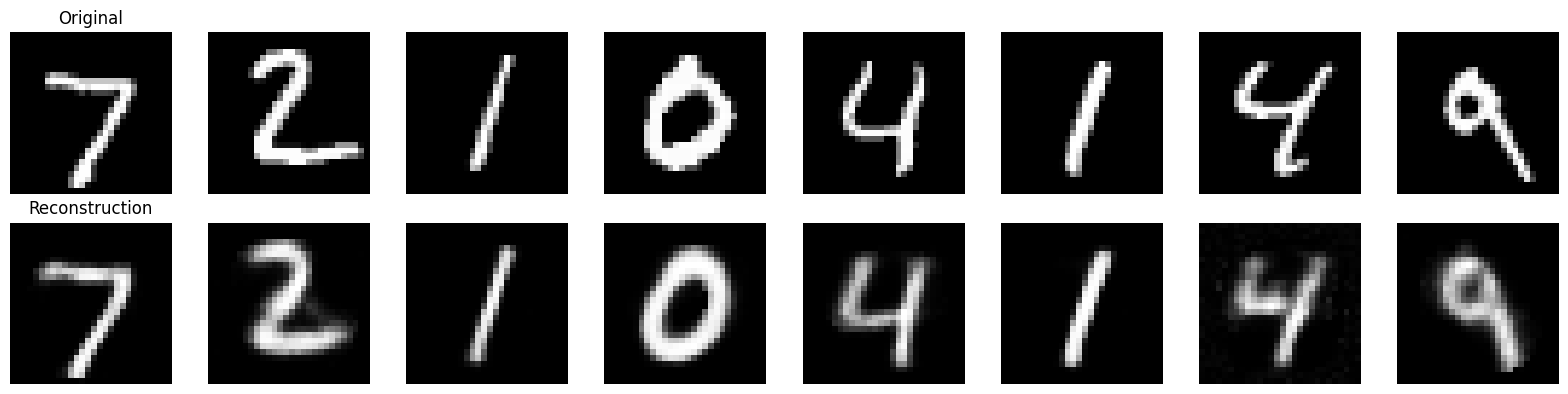

In [16]:
# plot some reconstructions
def plot_reconstructions(x_test, x_recon, n=8):
    plt.figure(figsize=(2*n,4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(x_test[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i==0:
            ax.set_title('Original')
        ax = plt.subplot(2,n,n+i+1)
        plt.imshow(x_recon[i].reshape(28,28), cmap='gray')
        plt.axis('off')
        if i==0:
            ax.set_title('Reconstruction')
    plt.tight_layout()

plot_reconstructions(x_test_flat, x_test_recon, n=8)

## Extract latent features and train NumPy one-vs-rest linear SVM
We standardize the latent features and train linear classifiers using SGD on hinge loss.

In [22]:
# extract latent features
z_train = encoder.predict(x_train_flat)
z_test = encoder.predict(x_test_flat)
print('Latent shapes:', z_train.shape, z_test.shape)

# standardize
mean = z_train.mean(axis=0)
std = z_train.std(axis=0) + 1e-9
z_train_s = (z_train - mean) / std
z_test_s = (z_test - mean) / std

# simple one-vs-rest linear SVM (hinge loss)
def train_linear_svm_ovr(X, y, n_classes=10, C=1.0, lr=1e-2, epochs=10, batch_size=32):
    n_samples, n_features = X.shape
    W = np.zeros((n_classes, n_features), dtype=np.float32)
    b = np.zeros(n_classes, dtype=np.float32)
    lambda_reg = 1.0 / (n_samples * C)
    for epoch in range(1, epochs+1):
        idx = np.arange(n_samples)
        np.random.shuffle(idx)
        X_sh = X[idx]
        y_sh = y[idx]
        for i in range(0, n_samples, batch_size):
            xb = X_sh[i:i+batch_size]
            yb = y_sh[i:i+batch_size]
            for k in range(n_classes):
                yk = np.where(yb==k, 1.0, -1.0)
                scores = xb.dot(W[k]) + b[k]
                margins = yk * scores
                mask = margins < 1.0
                if np.any(mask):
                    grad_w = -np.mean((yk[mask][:,None] * xb[mask]), axis=0) + lambda_reg * W[k]
                    grad_b = -np.mean(yk[mask])
                else:
                    grad_w = lambda_reg * W[k]
                    grad_b = 0.0
                W[k] -= lr * grad_w
                b[k] -= lr * grad_b
        if epoch==1 or epoch%max(1, epochs//5)==0:
            preds = np.argmax(X.dot(W.T) + b[None,:], axis=1)
            acc = np.mean(preds == y)
            print(f'Epoch {epoch}/{epochs} - approx training accuracy: {acc:.4f}')
    return W, b

W, b = train_linear_svm_ovr(z_train_s, y_train, n_classes=10, C=1.0, lr=1e-2, epochs=200, batch_size=32)
y_pred = np.argmax(z_test_s.dot(W.T) + b[None,:], axis=1)
acc = np.mean(y_pred == y_test)
print('SVM test accuracy:', acc)

Latent shapes: (60000, 32) (10000, 32)
Epoch 1/200 - approx training accuracy: 0.8136
Epoch 1/200 - approx training accuracy: 0.8136
Epoch 40/200 - approx training accuracy: 0.8814
Epoch 40/200 - approx training accuracy: 0.8814
Epoch 80/200 - approx training accuracy: 0.8927
Epoch 80/200 - approx training accuracy: 0.8927
Epoch 120/200 - approx training accuracy: 0.8945
Epoch 120/200 - approx training accuracy: 0.8945
Epoch 160/200 - approx training accuracy: 0.8958
Epoch 160/200 - approx training accuracy: 0.8958
Epoch 200/200 - approx training accuracy: 0.8955
SVM test accuracy: 0.9012
Epoch 200/200 - approx training accuracy: 0.8955
SVM test accuracy: 0.9012


In [ ]:
# confusion matrix and simple report
def confusion_matrix(y_true, y_pred, n_classes=10):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[t,p] += 1
    return cm

def classification_report_from_cm(cm):
    report = {}
    for k in range(cm.shape[0]):
        tp = cm[k,k]
        fp = cm[:,k].sum() - tp
        fn = cm[k,:].sum() - tp
        prec = tp / (tp+fp) if (tp+fp) > 0 else 0.0
        rec = tp / (tp+fn) if (tp+fn) > 0 else 0.0
        f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
        report[k] = {'precision': prec, 'recall': rec, 'f1-score': f1, 'support': int(cm[k,:].sum())}
    report['macro avg'] = {'precision': float(np.mean([report[k]['precision'] for k in report if k!='macro avg'])),
                           'recall': float(np.mean([report[k]['recall'] for k in report if k!='macro avg'])),
                           'f1-score': float(np.mean([report[k]['f1-score'] for k in report if k!='macro avg'])),
                           'support': int(sum(report[k]['support'] for k in report if k!='macro avg'))}
    return report

cm = confusion_matrix(y_test, y_pred, n_classes=10)
print('Confusion matrix:\n', cm)
report = classification_report_from_cm(cm)
for k in range(10):
    r = report[k]
    print(f'Class {k}: precision={r["precision"]:.3f}, recall={r["recall"]:.3f}, f1={r["f1-score"]:.3f}, support={r["support"]}')
print('Macro avg:', report['macro avg'])

# Plot confusion matrix heatmap
os.makedirs('outputs', exist_ok=True)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
tick_marks = np.arange(cm.shape[0])
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels([str(i) for i in range(cm.shape[0])])
ax.set_yticklabels([str(i) for i in range(cm.shape[0])])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# annotate cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')
fig.colorbar(im, ax=ax)
plt.tight_layout()
fig.savefig(os.path.join('outputs','confusion_matrix.png'), dpi=150)
plt.show()

Confusion matrix:
 [[ 958    0    1    0    1    5    7    1    7    0]
 [   0 1118    3    3    2    2    1    1    5    0]
 [  12    0  953    9    2    1    3    8   44    0]
 [   2    1   10  912    1   19    3    7   52    3]
 [   5    1    1    9  865    2   11    9   12   67]
 [   4    2    0  101   17  665   18    2   73   10]
 [   9    3    0    0    7   18  919    0    2    0]
 [   2   10   17    4    9    1    0  920   15   50]
 [   3    0   12   53    3   23    4    4  858   14]
 [   8    9    4   16   77    1    1   33   16  844]]
Class 0: precision=0.955, recall=0.978, f1=0.966, support=980
Class 1: precision=0.977, recall=0.985, f1=0.981, support=1135
Class 2: precision=0.952, recall=0.923, f1=0.938, support=1032
Class 3: precision=0.824, recall=0.903, f1=0.862, support=1010
Class 4: precision=0.879, recall=0.881, f1=0.880, support=982
Class 5: precision=0.902, recall=0.746, f1=0.816, support=892
Class 6: precision=0.950, recall=0.959, f1=0.955, support=958
Class 7: prec

## Save artifacts
We save learned weights (NumPy arrays) and the latent scaler to `models/`.

In [19]:
os.makedirs('models', exist_ok=True)
# save encoder+decoder dense weights by index
weights = {}
i = 0
for layer in encoder_layers + decoder_layers:
    if hasattr(layer, 'W'):
        weights[f'layer_{i}_W'] = layer.W
        if layer.b is not None:
            weights[f'layer_{i}_b'] = layer.b
    i += 1
np.savez(os.path.join('models','autoencoder_weights.npz'), **weights)
np.savez(os.path.join('models','latent_scaler.npz'), mean=mean, std=std)
np.savez(os.path.join('models','svm_linear_ovr.npz'), W=W, b=b)
print('Saved models to models/ and outputs/reconstructions.png')

Saved models to models/ and outputs/reconstructions.png


## Loading and using saved models for inference

After training, you can load the saved weights and use the encoder + SVM for predictions on new data.

In [20]:
# Reload the encoder and SVM for inference (fresh session)
# This demonstrates how to use saved models later

# Rebuild encoder layers (architecture must match training)
enc_fc1_reload = Dense(256, init='xavier')
enc_act1_reload = ReLU()
enc_fc2_reload = Dense(128, init='xavier')
enc_act2_reload = ReLU()
enc_latent_reload = Dense(latent_dim, init='xavier')
enc_latent_act_reload = ReLU()

encoder_layers_reload = [enc_fc1_reload, enc_act1_reload, enc_fc2_reload, enc_act2_reload, 
                          enc_latent_reload, enc_latent_act_reload]
encoder_reload = build_encoder_model(encoder_layers_reload)

# Initialize with dummy forward
dummy = np.zeros((1, 28*28), dtype=np.float32)
_ = encoder_reload.predict(dummy)

# Load saved weights
encoder_reload.load_weights('models/autoencoder_weights.npz')

# Load scaler and SVM
scaler_data = np.load('models/latent_scaler.npz', allow_pickle=True)
mean_loaded = scaler_data['mean']
std_loaded = scaler_data['std']

svm_data = np.load('models/svm_linear_ovr.npz', allow_pickle=True)
W_loaded = svm_data['W']
b_loaded = svm_data['b']

print('Models reloaded successfully!')


Error loading weights: could not broadcast input array from shape (784,512) into shape (784,256)


ValueError: could not broadcast input array from shape (784,512) into shape (784,256)

In [ ]:
# Example: predict digit class from a single test image using loaded models
def predict_digit(x_flat, encoder, W, b, mean, std):
    """Encode image, normalize, and predict digit class."""
    if x_flat.ndim == 1:
        x_flat = x_flat[np.newaxis, :]
    z = encoder.predict(x_flat)
    z_normalized = (z - mean) / std
    scores = z_normalized.dot(W.T) + b[np.newaxis, :]
    pred = np.argmax(scores, axis=1)[0]
    return pred

# Test on a few random samples
test_sample_indices = [42, 100, 500, 999, 5000]
print('Predictions on sample test images:')
for idx in test_sample_indices:
    y_true = y_test[idx]
    y_pred = predict_digit(x_test_flat[idx], encoder_reload, W_loaded, b_loaded, mean_loaded, std_loaded)
    match = '✓' if y_pred == y_true else '✗'
    print(f'  Image {idx}: True={y_true}, Pred={y_pred} {match}')
